<a href="https://colab.research.google.com/github/Hesdi/KyrgyzNER/blob/main/kyrgyz_ner_2023_baseline_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# установка необходимых библиотек
!pip install deeppavlov
!pip install transformers==4.31.0
!pip install pytorch-crf

In [ ]:
from itertools import groupby
from collections import namedtuple

Sentence = namedtuple("Sentence", "id tokens tags")

def get_sentences(filename):
    """
    filename - путь до train/test файла от организаторов соревнования

    Возвращает список предложений в структуре Sentence(id, tokens, tags).
    """
    with open(filename, "r") as inp:
        lines = inp.readlines()

    sentences = [list(sentence) for k, sentence in groupby(lines, key=lambda x: x.strip() != "") if k]
    sentences = [Sentence(s[0].strip(), [t.split("\t")[0].strip() for t in s[1:]], [t.split("\t")[-1].strip() for t in s[1:]]) for s in sentences]

    return sentences


def kyrgyz_ner_2_deeppavlov_ner(source, destination):
    """
    source - путь до train файла от организаторов соревнования, который нужно
    сконвертировать в формат deeppavlov NER, чтобы можно было обучаться
    destination - путь, куда нужно сохранить сконвертированный файл

    Конвертит данные от организаторов в формат, который понимает система
    deeppavlov NER.
    """
    sentences = get_sentences(source)
    with open(destination, "w") as out:
        for s in sentences:
            for tok, tag in zip(s.tokens, s.tags):
                print(tok, tag, file=out)
            print("", file=out)

def write_predictions(sentences, predictions, destination):
    """
    sentences - список предложений, полученный из `get_sentences`
    predictions - предсказания, полученные из обученной NER модели
    destination - путь, по которому будет записан файл с предсказаниями

    """
    with open(destination, "w") as out:
        for sent, pred in zip(sentences, predictions):
            print(sent.id, file=out)
            for tok, p in zip(sent.tokens, pred):
                print(f"{tok}\t-\t-\t{p}", file=out)
            print("", file=out)

def ppath(name):
    return f"/content/drive/MyDrive/kyrgyz-ner-2023/{name}"

def flatten(x):
    from itertools import chain
    return list(chain(*x))

In [ ]:
import os
import collections
from sklearn.model_selection import train_test_split

# Создаем директорию, куда положим сконверченные данные
data_dir = "train_data"
os.makedirs(data_dir, exist_ok=True)

train_sentences = get_sentences(ppath("train.txt"))

sentence2labels = collections.defaultdict(set)
for sent in train_sentences:
    sentence2labels["_".join(sent.tokens)].add("_".join(sent.tags))

ambiguous_sentences = set([x[0] for x in sentence2labels.items() if len(x[1]) > 1])
print(f"Number of sentences before filtration: {len(train_sentences)}")
train_sentences = [x for x in train_sentences if "_".join(x.tokens) not in ambiguous_sentences and len(x.tokens) > 2]
print(f"Number of sentences after filtration: {len(train_sentences)}")

train, validation = train_test_split(train_sentences, test_size=0.25, random_state=2023)

write_predictions(train, [x.tags for x in train], f"{data_dir}/train.txt")
write_predictions(validation, [x.tags for x in validation], f"{data_dir}/valid.txt")

# # Так как это просто игрушечный бейзлайн, то просто возьмем в качестве train/valid/test
# # сетов весь обучающий файл (на хакатоне лучше так не делать)
# kyrgyz_ner_2_deeppavlov_ner("sample.conll2003-formatted.txt", f"{data_dir}/train.txt")
# kyrgyz_ner_2_deeppavlov_ner("sample.conll2003-formatted.txt", f"{data_dir}/valid.txt")
# kyrgyz_ner_2_deeppavlov_ner("sample.conll2003-formatted.txt", f"{data_dir}/test.txt")

Number of sentences before filtration: 5557
Number of sentences after filtration: 5276


In [ ]:
from deeppavlov import train_model
from deeppavlov.core.commands.utils import parse_config
import json
from copy import deepcopy

def change_pipe(x):
    if "class_name" in x and x["class_name"] == "torch_transformers_ner_preprocessor":
        x = deepcopy(x)
        x["max_seq_length"] = 256

    if "class_name" in x and x["class_name"] == "torch_transformers_sequence_tagger":
        x = deepcopy(x)
        x["optimizer_parameters"]["lr"] = 1e-4
        x["optimizer_parameters"]["weight_decay"] = 1e-4

    return x
# Загружаем конфиг мультилингвального BERTа и заменяем путь до обучающих данных на свой
model_config = parse_config('ner_ontonotes_bert_mult')
model_config["dataset_reader"]["data_path"] = data_dir
# model_config["train"]["epochs"] = 6
model_config["train"]["batch_size"] = 50
model_config["train"]["validation_patience"] = 30
model_config["train"]["val_every_n_batches"] = 4
model_config["train"]["validation_patience"] = 4
# model_config["chainer"]["pipe"] = [change_pipe(x) for x in model_config["chainer"]["pipe"]]
model_config["train"]["metrics"] = [
    {
        "name": "ner_f1",
        "inputs": [
            "y",
            "y_pred"
        ]
    }
]
print(json.dumps(model_config, indent=4))

{
    "dataset_reader": {
        "class_name": "conll2003_reader",
        "data_path": "train_data",
        "dataset_name": "ontonotes",
        "provide_pos": false
    },
    "dataset_iterator": {
        "class_name": "data_learning_iterator"
    },
    "chainer": {
        "in": [
            "x"
        ],
        "in_y": [
            "y"
        ],
        "pipe": [
            {
                "class_name": "torch_transformers_ner_preprocessor",
                "vocab_file": "bert-base-multilingual-cased",
                "do_lower_case": false,
                "max_seq_length": 512,
                "max_subword_length": 15,
                "token_masking_prob": 0.0,
                "in": [
                    "x"
                ],
                "out": [
                    "x_tokens",
                    "x_subword_tokens",
                    "x_subword_tok_ids",
                    "startofword_markers",
                    "attention_mask",
                    "token

In [ ]:
# Обучаем модель
ner_model = train_model(model_config)

2023-07-28 19:08:59.474 WARNING in 'deeppavlov.core.trainers.fit_trainer'['fit_trainer'] at line 66: TorchTrainer got additional init parameters ['pytest_max_batches', 'pytest_batch_size'] that will be ignored:


2023-07-28 19:09:25.12 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 104: [saving vocabulary to /root/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/tag.dict]
INFO:deeppavlov.core.data.simple_vocab:[saving vocabulary to /root/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/tag.dict]


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2023-07-28 19:09:34.682 WARNING in 'deeppavlov.models.torch_bert.torch_transformers_sequence_tagger'['torch_transformers_sequence_tagger'] at line 310: Init from scratch. Load path /root/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/model_crf.pth.tar does not exist.
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:493.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
27it [05:30, 12.25s/it]
2023-07-28 19:

{"valid": {"eval_examples_count": 1319, "metrics": {"ner_f1": 0.2742}, "time_spent": "0:05:32", "epochs_done": 0, "batches_seen": 0, "train_examples_seen": 0, "impatience": 0, "patience_limit": 4}}


INFO:train_report:{"valid": {"eval_examples_count": 1319, "metrics": {"ner_f1": 0.2742}, "time_spent": "0:05:32", "epochs_done": 0, "batches_seen": 0, "train_examples_seen": 0, "impatience": 0, "patience_limit": 4}}
3it [02:27, 50.78s/it]
0it [00:00, ?it/s]
1it [00:09,  9.14s/it]
2it [00:21, 11.03s/it]
3it [00:32, 11.04s/it]
4it [00:40,  9.90s/it]
5it [00:49,  9.68s/it]
6it [01:00, 10.04s/it]
7it [01:14, 11.21s/it]
8it [01:25, 11.28s/it]
9it [01:34, 10.56s/it]
10it [01:47, 11.15s/it]
11it [01:59, 11.59s/it]
12it [02:10, 11.41s/it]
13it [02:24, 12.06s/it]
14it [02:37, 12.45s/it]
15it [02:48, 11.80s/it]
16it [02:59, 11.67s/it]
17it [03:07, 10.66s/it]
18it [03:20, 11.26s/it]
19it [03:29, 10.72s/it]
20it [03:40, 10.82s/it]
21it [03:54, 11.55s/it]
22it [04:05, 11.63s/it]
23it [04:23, 13.40s/it]
24it [04:36, 13.39s/it]
25it [04:51, 13.74s/it]
26it [05:03, 13.40s/it]
27it [05:08, 11.41s/it]
2023-07-28 19:23:21.621 INFO in 'deeppavlov.core.trainers.nn_trainer'['nn_trainer'] at line 211: Did no

{"valid": {"eval_examples_count": 1319, "metrics": {"ner_f1": 0}, "time_spent": "0:13:47", "epochs_done": 0, "batches_seen": 4, "train_examples_seen": 200, "impatience": 1, "patience_limit": 4}}


INFO:train_report:{"valid": {"eval_examples_count": 1319, "metrics": {"ner_f1": 0}, "time_spent": "0:13:47", "epochs_done": 0, "batches_seen": 4, "train_examples_seen": 200, "impatience": 1, "patience_limit": 4}}
7it [10:11, 74.90s/it]
0it [00:00, ?it/s]
1it [00:12, 12.08s/it]
2it [00:21, 10.45s/it]
3it [00:33, 11.22s/it]
4it [00:41,  9.78s/it]
5it [00:51,  9.90s/it]
6it [01:02, 10.44s/it]
7it [01:14, 10.82s/it]
8it [01:27, 11.44s/it]
9it [01:35, 10.56s/it]
10it [01:47, 11.04s/it]
11it [02:04, 12.79s/it]
12it [02:15, 12.36s/it]
13it [02:27, 12.02s/it]
14it [02:41, 12.76s/it]
15it [02:53, 12.55s/it]
16it [03:02, 11.30s/it]
17it [03:13, 11.30s/it]
18it [03:23, 11.08s/it]
19it [03:34, 10.84s/it]
20it [03:46, 11.12s/it]
21it [03:56, 11.01s/it]
22it [04:10, 11.72s/it]
23it [04:28, 13.58s/it]
24it [04:42, 13.93s/it]
25it [04:56, 13.81s/it]
26it [05:07, 12.90s/it]
27it [05:12, 11.57s/it]
2023-07-28 19:30:59.82 INFO in 'deeppavlov.core.trainers.nn_trainer'['nn_trainer'] at line 211: Did not im

{"valid": {"eval_examples_count": 1319, "metrics": {"ner_f1": 0}, "time_spent": "0:21:25", "epochs_done": 0, "batches_seen": 8, "train_examples_seen": 400, "impatience": 2, "patience_limit": 4}}


INFO:train_report:{"valid": {"eval_examples_count": 1319, "metrics": {"ner_f1": 0}, "time_spent": "0:21:25", "epochs_done": 0, "batches_seen": 8, "train_examples_seen": 400, "impatience": 2, "patience_limit": 4}}
10it [17:55, 107.52s/it]
2023-07-28 19:33:01.4 INFO in 'deeppavlov.core.trainers.nn_trainer'['nn_trainer'] at line 336: Stopped training
INFO:deeppavlov.core.trainers.nn_trainer:Stopped training
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2023-07-28 19:33:08.606 WARNING in 'deeppavlov.models.torch_bert.torch_transformers_sequence_tagger'['torch_transformers_sequence_tagger'] at line 310: Init from scratch. Load path /root/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/model_crf.pth.tar does not exist.
27it [05:28, 12.1

{"valid": {"eval_examples_count": 1319, "metrics": {"ner_f1": 0.0276}, "time_spent": "0:05:30"}}


INFO:train_report:{"valid": {"eval_examples_count": 1319, "metrics": {"ner_f1": 0.0276}, "time_spent": "0:05:30"}}
0it [00:00, ?it/s]
2023-07-28 19:38:37.641 WARNING in 'deeppavlov.core.trainers.fit_trainer'['fit_trainer'] at line 173: Got empty data iterable for scoring


{"test": {"eval_examples_count": 0, "metrics": null, "time_spent": "0:00:00"}}


INFO:train_report:{"test": {"eval_examples_count": 0, "metrics": null, "time_spent": "0:00:00"}}
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2023-07-28 19:38:41.433 WARNING in 'deeppavlov.models.torch_bert.torch_transformers_sequence_tagger'['torch_transformers_sequence_tagger'] at line 310: Init from scratch. Load path /root/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/model_crf.pth.tar does not exist.


In [ ]:
# Делаем предсказания для файла "sample.conll2003-formatted.txt"
sentences = get_sentences(ppath("test.txt"))

from itertools import islice
def batched(iterable, n):
    "Batch data into tuples of length n. The last batch may be shorter."
    # batched('ABCDEFG', 3) --> ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while batch := tuple(islice(it, n)):
        yield batch

all_predictions = []
for batch in batched([s.tokens for s in sentences], 32):
    _, predictions = ner_model(batch)
    all_predictions.extend(predictions)

KeyboardInterrupt: ignored

In [ ]:
from datetime import datetime
from collections import Counter
from matplotlib import pyplot as plt

In [ ]:
# Записываем предсказанные результаты в выходной файл `predictions.txt` в формате хакатона
write_predictions(sentences, all_predictions, ppath(f"predictions-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}.txt"))

In [ ]:
# Делаем предсказания для файла "sample.conll2003-formatted.txt"
sentences = get_sentences("train_data/valid.txt")

all_predictions = []
for batch in batched([s.tokens for s in sentences], 32):
    _, predictions = ner_model(batch)
    all_predictions.extend(predictions)

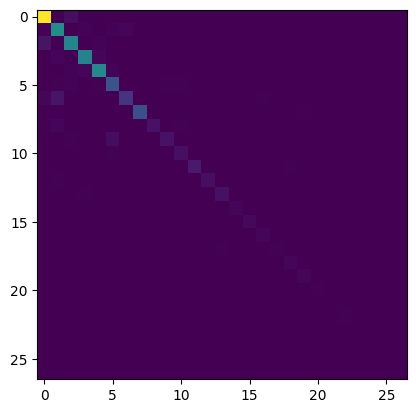

In [ ]:
from sklearn.metrics import confusion_matrix
labels = [x[0] for x in Counter(flatten([x.tags for x in sentences])).most_common() if x[0] != "O"]
plt.imshow(
    confusion_matrix(
        flatten([x.tags for x in sentences]),
        flatten(all_predictions),
        labels=labels
    )
)

In [ ]:
len(train_sentences)

5397

In [ ]:
from pandas.core.reshape.encoding import defaultdict
total = 0
wrong = 0
wrong_transitions = []
for sent, pred in zip(sentences, all_predictions):
    total += 1
    if "_".join(sent.tags) != "_".join(pred):
        wrong += 1
        print("=" * 20)
        print(" ".join([f"{w}/{g}/{p}" for w, g, p in zip(sent.tokens, sent.tags, pred) if g != p and g == "O" and p == "I-PERSON"]), f"     {' '.join(sent.tokens)}")
        for g, p in zip(sent.tags, pred):
            if g != p:
                wrong_transitions.append((g, p))

print(wrong * 100 / total, "%")
Counter(wrong_transitions).most_common()

      Мурда аткаминерлер өзүнүн отставкасын ЖМКдан билчү .
      Эл аралык сынак Москва шаарында Чоң театрда өтүп жатат .
      Анын кайрылуусу каралып бүткөнчө , Zanoza интернет басылмасына каршы соттук териштирүү токтоп турушу керек болчу .
      Бул тууралуу « 24 . kg » агентигине Шайлоо жана референдум өткөрүү боюнча борбордук комиссиясынын мүчөсү Абдыжапар Бекматов билдирди .
      Өкмөт Жамааттык коопсуздук келишими уюмуна Кыргызстанда курал-жарак чыгарган ишкана ачууну сунуштады .
Текебаев/O/I-PERSON      Өмүрбек Текебаев менен Дүйшөн Чотоновдун сотунда айыптоо корутундусу окулду .
      Мурдакы Акыйкатчы Турсунбек Акун дагы шайлоого катышат .
./O/I-PERSON А/O/I-PERSON ./O/I-PERSON      Анын жыйынтыгында К . А .
      Алар Катардан « Мусулман агайындар » кыймылы , « Хезболла » , « Аль-Каида » жана « Ислам мамлекети » топтору менен байланыштарын токтотууну талап кылышууда .
      Бул тууралуу « 24 . kg » агентигине өкмөттүн облустагы ыйгарым укуктуу өкүлчүлүгүнүн маалымат кызматы

[(('O', 'I-PERSON'), 84),
 (('O', 'I-LOCATION'), 73),
 (('O', 'I-INSTITUTION'), 66),
 (('O', 'B-LOCATION'), 57),
 (('I-LOCATION', 'O'), 49),
 (('I-PERSON', 'O'), 45),
 (('O', 'B-PERSON'), 42),
 (('I-ORGANISATION', 'I-INSTITUTION'), 39),
 (('B-PERSON', 'I-PERSON'), 35),
 (('I-PERSON', 'B-PERSON'), 26),
 (('B-TITLE', 'O'), 26),
 (('O', 'B-INSTITUTION'), 23),
 (('B-ORGANISATION', 'B-INSTITUTION'), 22),
 (('O', 'B-TITLE'), 22),
 (('I-INSTITUTION', 'O'), 22),
 (('B-PERSON', 'O'), 18),
 (('B-INSTITUTION', 'O'), 18),
 (('I-ORGANISATION', 'O'), 18),
 (('I-TITLE', 'O'), 17),
 (('I-EVENT', 'O'), 16),
 (('B-LOCATION', 'O'), 16),
 (('I-TITLE', 'I-INSTITUTION'), 13),
 (('I-LOCATION', 'B-LOCATION'), 12),
 (('I-ORGANISATION', 'I-PERSON'), 11),
 (('O', 'I-TITLE'), 10),
 (('O', 'I-BUSINESS'), 10),
 (('I-INSTITUTION', 'I-ORGANISATION'), 10),
 (('B-LOCATION', 'I-LOCATION'), 10),
 (('I-LOCATION', 'I-INSTITUTION'), 9),
 (('O', 'I-MEDIA'), 8),
 (('B-LOCATION', 'B-PERSON'), 7),
 (('B-LOCATION', 'B-INSTITUTIO

In [ ]:
from pandas.core.reshape.encoding import defaultdict
total = 0
wrong = 0
wrong_transitions = []
for sent, pred in zip(sentences, all_predictions):
    total += 1
    if "_".join(sent.tags) != "_".join(pred):
        wrong += 1
        print("=" * 20)
        print(" ".join([f"{w}/{g}/{p}" for w, g, p in zip(sent.tokens, sent.tags, pred) if g != p]), f"     {' '.join(sent.tokens)}")
        for g, p in zip(sent.tags, pred):
            if g != p:
                wrong_transitions.append((g, p))

print(wrong * 100 / total, "%")
Counter(wrong_transitions).most_common()

ЖМКдан/O/B-INSTITUTION      Мурда аткаминерлер өзүнүн отставкасын ЖМКдан билчү .
Чоң театрда/I-LOCATION/B-LOCATION      Эл аралык сынак Москва шаарында Чоң театрда өтүп жатат .
Zanoza/B-WEBSITE/B-MEDIA      Анын кайрылуусу каралып бүткөнчө , Zanoza интернет басылмасына каршы соттук териштирүү токтоп турушу керек болчу .
Шайлоо/B-EVENT/O жана/I-EVENT/O референдум/I-EVENT/O борбордук/B-PERSON/O комиссиясынын/I-PERSON/O мүчөсү/I-PERSON/O Абдыжапар/I-PERSON/B-PERSON      Бул тууралуу « 24 . kg » агентигине Шайлоо жана референдум өткөрүү боюнча борбордук комиссиясынын мүчөсү Абдыжапар Бекматов билдирди .
Өкмөт/B-INSTITUTION/O Жамааттык/I-INSTITUTION/B-INSTITUTION      Өкмөт Жамааттык коопсуздук келишими уюмуна Кыргызстанда курал-жарак чыгарган ишкана ачууну сунуштады .
Өмүрбек/O/B-PERSON Текебаев/O/I-PERSON Дүйшөн/O/B-LOCATION      Өмүрбек Текебаев менен Дүйшөн Чотоновдун сотунда айыптоо корутундусу окулду .
Мурдакы/O/B-PERSON Акыйкатчы/B-PERSON/I-PERSON      Мурдакы Акыйкатчы Турсунбек Аку

[(('O', 'I-PERSON'), 84),
 (('O', 'I-LOCATION'), 73),
 (('O', 'I-INSTITUTION'), 66),
 (('O', 'B-LOCATION'), 57),
 (('I-LOCATION', 'O'), 49),
 (('I-PERSON', 'O'), 45),
 (('O', 'B-PERSON'), 42),
 (('I-ORGANISATION', 'I-INSTITUTION'), 39),
 (('B-PERSON', 'I-PERSON'), 35),
 (('I-PERSON', 'B-PERSON'), 26),
 (('B-TITLE', 'O'), 26),
 (('O', 'B-INSTITUTION'), 23),
 (('B-ORGANISATION', 'B-INSTITUTION'), 22),
 (('O', 'B-TITLE'), 22),
 (('I-INSTITUTION', 'O'), 22),
 (('B-PERSON', 'O'), 18),
 (('B-INSTITUTION', 'O'), 18),
 (('I-ORGANISATION', 'O'), 18),
 (('I-TITLE', 'O'), 17),
 (('I-EVENT', 'O'), 16),
 (('B-LOCATION', 'O'), 16),
 (('I-TITLE', 'I-INSTITUTION'), 13),
 (('I-LOCATION', 'B-LOCATION'), 12),
 (('I-ORGANISATION', 'I-PERSON'), 11),
 (('O', 'I-TITLE'), 10),
 (('O', 'I-BUSINESS'), 10),
 (('I-INSTITUTION', 'I-ORGANISATION'), 10),
 (('B-LOCATION', 'I-LOCATION'), 10),
 (('I-LOCATION', 'I-INSTITUTION'), 9),
 (('O', 'I-MEDIA'), 8),
 (('B-LOCATION', 'B-PERSON'), 7),
 (('B-LOCATION', 'B-INSTITUTIO

In [ ]:
confusion_matrix(flatten([x.tags for x in sentences]), flatten(all_predictions))

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            3],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            2],
       [    0,     0,    20,     0,     0,     0,     0,     1,     0,
            1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            3],
       [    0,     0,     0,     5,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     7,     0,     1,     0,     0,
            1

In [ ]:
train_sentences = get_sentences(ppath("train.txt"))
test_sentences = get_sentences(ppath("test.txt"))

NameError: ignored

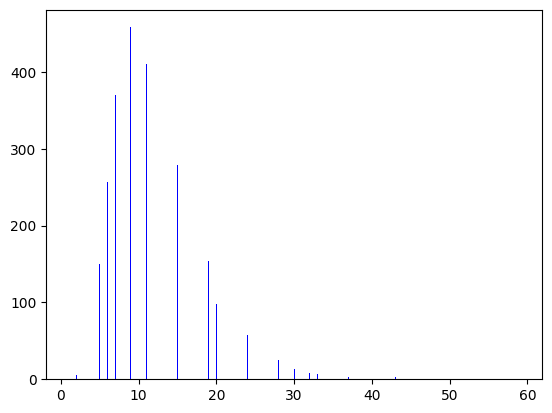

In [ ]:
from matplotlib import pyplot as plt

plt.hist([len(x.tokens) for x in train_sentences], color="blue", bins=1000)
plt.hist([len(x.tokens) for x in test_sentences], color="red", alpha=0.7, bins=1000)
# plt.boxplot([len(x.tokens) for x in train_sentences])

In [ ]:
# Собираем ансамбль из 3-х сабмитов
from glob import glob
from collections import Counter

ansamble_sentences = []

for s1, s2, s3 in zip(*(get_sentences(file) for file in glob(ppath("predictions*")))):
    assert s1.id == s2.id == s3.id
    assert len(s1.tokens) == len(s2.tokens) == len(s3.tokens)
    ansamble_sentences.append(
        Sentence(
            s1.id,
            s2.tokens,
            [Counter([t1, t2, t3]).most_common()[0][0] for t1, t2, t3 in zip(s1.tags, s2.tags, s3.tags)]
        )
    )

In [ ]:
write_predictions(ansamble_sentences, [x.tags for x in ansamble_sentences], ppath("ansamble_from_first_3_sumbitted.txt"))

In [ ]:
ansamble_sentences

[Sentence(id='# 1', tokens=['1-мартта', 'Бишкек', 'шаарындагы', 'борбордук', 'мечитте', 'республикалык', 'Куран', 'жарышы', 'башталды', '.'], tags=['O', 'B-LOCATION', 'I-LOCATION', 'I-LOCATION', 'I-LOCATION', 'O', 'I-INSTITUTION', 'O', 'O', 'O']),
 Sentence(id='# 2', tokens=['Куран', 'жарышына', 'өлкө', 'аймагындагы', 'тандоо', 'турунан', 'өткөн', '82', 'талапкерлер', 'катышып', ',', 'өз', 'күчтөрүн', 'сынашууда', '.'], tags=['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 Sentence(id='# 3', tokens=['Бул', 'тууралуу', 'Муфтияттын', 'басма сөз', 'кызматы', 'билдирди', '.'], tags=['O', 'O', 'B-INSTITUTION', 'O', 'O', 'O', 'O']),
 Sentence(id='# 4', tokens=['«', 'Куран', 'жарышы', 'балдардын', 'Куранга', 'болгон', 'сүйүүсүн', 'бекемдеп', ',', 'ыймандуулукту', ',', 'адептүүлүктү', 'жана', 'жан', 'дүйнөнүн', 'тазарышына', 'түрткү', 'берет', '.'], tags=['O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 Sen

In [ ]:
from collections import Counter
Counter([x[2:] for x in flatten([x.tags for x in train_sentences]) if x != 'O']).most_common()

[('PERSON', 5036),
 ('LOCATION', 3226),
 ('INSTITUTION', 2351),
 ('MEDIA', 971),
 ('ORGANISATION', 965),
 ('TITLE', 483),
 ('BUSINESS', 387),
 ('EVENT', 286),
 ('INSTALLATION', 159),
 ('WEBSITE', 124),
 ('CREATION', 97),
 ('UNKNOWN', 29),
 ('AWARD', 22),
 ('ANIMAL', 6)]

In [ ]:
from itertools import chain
plt.hist(list(chain(*[x.tags for x in train_sentences])), color="blue")
plt.hist(list(chain(*[x.tags for x in test_sentences])), color="red", alpha=0.7)

(array([26091.,  6082.,  3826.,  2920.,  2518.,  2298.,  1867.,  1676.,
         1504.,  1427.]),
 array([   28. ,  1278.4,  2528.8,  3779.2,  5029.6,  6280. ,  7530.4,
         8780.8, 10031.2, 11281.6, 12532. ]),
 <BarContainer object of 10 artists>)

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7c51676a5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


Error in callback <function flush_figures at 0x7c51c54b5cf0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
plt.boxplot([len(x.tokens) for x in train_sentences])

In [ ]:
len([x for x in train_sentences if len(x.tokens) >= 50])

4

In [ ]:
146 / len(train_sentences)

0.026273168976066224

1 submit
{
    "dataset_reader": {
        "class_name": "conll2003_reader",
        "data_path": "train_data",
        "dataset_name": "ontonotes",
        "provide_pos": false
    },
    "dataset_iterator": {
        "class_name": "data_learning_iterator"
    },
    "chainer": {
        "in": [
            "x"
        ],
        "in_y": [
            "y"
        ],
        "pipe": [
            {
                "class_name": "torch_transformers_ner_preprocessor",
                "vocab_file": "bert-base-multilingual-cased",
                "do_lower_case": false,
                "max_seq_length": 512,
                "max_subword_length": 15,
                "token_masking_prob": 0.0,
                "in": [
                    "x"
                ],
                "out": [
                    "x_tokens",
                    "x_subword_tokens",
                    "x_subword_tok_ids",
                    "startofword_markers",
                    "attention_mask",
                    "tokens_offsets"
                ]
            },
            {
                "id": "tag_vocab",
                "class_name": "simple_vocab",
                "unk_token": [
                    "O"
                ],
                "pad_with_zeros": true,
                "save_path": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/tag.dict",
                "load_path": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/tag.dict",
                "fit_on": [
                    "y"
                ],
                "in": [
                    "y"
                ],
                "out": [
                    "y_ind"
                ]
            },
            {
                "class_name": "torch_transformers_sequence_tagger",
                "n_tags": "#tag_vocab.len",
                "pretrained_bert": "bert-base-multilingual-cased",
                "attention_probs_keep_prob": 0.5,
                "use_crf": true,
                "encoder_layer_ids": [
                    -1
                ],
                "optimizer": "AdamW",
                "optimizer_parameters": {
                    "lr": 2e-05,
                    "weight_decay": 1e-06,
                    "betas": [
                        0.9,
                        0.999
                    ],
                    "eps": 1e-06
                },
                "clip_norm": 1.0,
                "min_learning_rate": 1e-07,
                "learning_rate_drop_patience": 30,
                "learning_rate_drop_div": 1.5,
                "load_before_drop": true,
                "save_path": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/model",
                "load_path": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/model",
                "in": [
                    "x_subword_tok_ids",
                    "attention_mask",
                    "startofword_markers"
                ],
                "in_y": [
                    "y_ind"
                ],
                "out": [
                    "y_pred_ind",
                    "probas"
                ]
            },
            {
                "ref": "tag_vocab",
                "in": [
                    "y_pred_ind"
                ],
                "out": [
                    "y_pred"
                ]
            }
        ],
        "out": [
            "x_tokens",
            "y_pred"
        ]
    },
    "train": {
        "epochs": 30,
        "batch_size": 16,
        "metrics": [
            {
                "name": "ner_f1",
                "inputs": [
                    "y",
                    "y_pred"
                ]
            },
            {
                "name": "ner_token_f1",
                "inputs": [
                    "y",
                    "y_pred"
                ]
            }
        ],
        "validation_patience": 100,
        "val_every_n_batches": 20,
        "log_every_n_batches": 20,
        "show_examples": false,
        "pytest_max_batches": 2,
        "pytest_batch_size": 8,
        "evaluation_targets": [
            "valid",
            "test"
        ],
        "class_name": "torch_trainer"
    },
    "metadata": {
        "variables": {
            "ROOT_PATH": "~/.deeppavlov",
            "DOWNLOADS_PATH": "~/.deeppavlov/downloads",
            "MODELS_PATH": "~/.deeppavlov/models",
            "TRANSFORMER": "bert-base-multilingual-cased",
            "MODEL_PATH": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf"
        },
        "download": [
            {
                "url": "http://files.deeppavlov.ai/v1/ner/ner_ontonotes_bert_mult_torch_crf.tar.gz",
                "subdir": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf"
            }
        ],
        "requirements": [
            "/usr/local/lib/python3.10/dist-packages/deeppavlov/requirements/pytorch.txt",
            "/usr/local/lib/python3.10/dist-packages/deeppavlov/requirements/transformers.txt",
            "/usr/local/lib/python3.10/dist-packages/deeppavlov/requirements/torchcrf.txt"
        ]
    }
}

2 submit - fail

In [ ]:
for i, sent in enumerate(train[10:30]):
    print(f"{i + 1}.", " ".join(sent.tokens))
    print(" ".join(f"{w}/{t}" for w, t in zip(sent.tokens, sent.tags)))

1. Бул талаптарды аткаруу үчүн Сауд Арабия , Египет , Бириккен Араб Эмираты жана Бахрейн Катарга 10 күндүк мөөнөт берди .
Бул/O талаптарды/O аткаруу/O үчүн/O Сауд Арабия/B-LOCATION ,/O Египет/B-LOCATION ,/O Бириккен/B-LOCATION Араб/I-LOCATION Эмираты/I-LOCATION жана/O Бахрейн/B-LOCATION Катарга/B-LOCATION 10/O күндүк/O мөөнөт/O берди/O ./O
2. Бул тууралуу Мамлекеттик бажы кызматы кабарлайт .
Бул/O тууралуу/O Мамлекеттик/B-INSTITUTION бажы/I-INSTITUTION кызматы/O кабарлайт/O ./O
3. « Шматрица » ишканасынын директору РуслаН Жунусов дагы президенттикке ат салышат .
«/B-PERSON Шматрица/I-PERSON »/I-PERSON ишканасынын/I-PERSON директору/I-PERSON РуслаН/I-PERSON Жунусов/I-PERSON дагы/O президенттикке/O ат/O салышат/O ./O
4. Бул тууралуу « Азаттыктын " түркмөн кызматы билдирет .
Бул/O тууралуу/O «/B-MEDIA Азаттыктын/I-MEDIA "/I-MEDIA түркмөн/O кызматы/O билдирет/O ./O
5. Күтүлгөндөй миллиондогон инвестиция келген жок .
Күтүлгөндөй/O миллиондогон/O инвестиция/O келген жок/O ./O
6. Ошол эле маа

3 submit
{
    "dataset_reader": {
        "class_name": "conll2003_reader",
        "data_path": "train_data",
        "dataset_name": "ontonotes",
        "provide_pos": false
    },
    "dataset_iterator": {
        "class_name": "data_learning_iterator"
    },
    "chainer": {
        "in": [
            "x"
        ],
        "in_y": [
            "y"
        ],
        "pipe": [
            {
                "class_name": "torch_transformers_ner_preprocessor",
                "vocab_file": "bert-base-multilingual-cased",
                "do_lower_case": false,
                "max_seq_length": 512,
                "max_subword_length": 15,
                "token_masking_prob": 0.0,
                "in": [
                    "x"
                ],
                "out": [
                    "x_tokens",
                    "x_subword_tokens",
                    "x_subword_tok_ids",
                    "startofword_markers",
                    "attention_mask",
                    "tokens_offsets"
                ]
            },
            {
                "id": "tag_vocab",
                "class_name": "simple_vocab",
                "unk_token": [
                    "O"
                ],
                "pad_with_zeros": true,
                "save_path": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/tag.dict",
                "load_path": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/tag.dict",
                "fit_on": [
                    "y"
                ],
                "in": [
                    "y"
                ],
                "out": [
                    "y_ind"
                ]
            },
            {
                "class_name": "torch_transformers_sequence_tagger",
                "n_tags": "#tag_vocab.len",
                "pretrained_bert": "bert-base-multilingual-cased",
                "attention_probs_keep_prob": 0.5,
                "use_crf": true,
                "encoder_layer_ids": [
                    -1
                ],
                "optimizer": "AdamW",
                "optimizer_parameters": {
                    "lr": 2e-05,
                    "weight_decay": 1e-06,
                    "betas": [
                        0.9,
                        0.999
                    ],
                    "eps": 1e-06
                },
                "clip_norm": 1.0,
                "min_learning_rate": 1e-07,
                "learning_rate_drop_patience": 30,
                "learning_rate_drop_div": 1.5,
                "load_before_drop": true,
                "save_path": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/model",
                "load_path": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf/model",
                "in": [
                    "x_subword_tok_ids",
                    "attention_mask",
                    "startofword_markers"
                ],
                "in_y": [
                    "y_ind"
                ],
                "out": [
                    "y_pred_ind",
                    "probas"
                ]
            },
            {
                "ref": "tag_vocab",
                "in": [
                    "y_pred_ind"
                ],
                "out": [
                    "y_pred"
                ]
            }
        ],
        "out": [
            "x_tokens",
            "y_pred"
        ]
    },
    "train": {
        "epochs": 30,
        "batch_size": 10,
        "metrics": [
            {
                "name": "ner_f1",
                "inputs": [
                    "y",
                    "y_pred"
                ]
            }
        ],
        "validation_patience": 100,
        "val_every_n_batches": 20,
        "log_every_n_batches": 20,
        "show_examples": false,
        "pytest_max_batches": 2,
        "pytest_batch_size": 8,
        "evaluation_targets": [
            "valid",
            "test"
        ],
        "class_name": "torch_trainer"
    },
    "metadata": {
        "variables": {
            "ROOT_PATH": "~/.deeppavlov",
            "DOWNLOADS_PATH": "~/.deeppavlov/downloads",
            "MODELS_PATH": "~/.deeppavlov/models",
            "TRANSFORMER": "bert-base-multilingual-cased",
            "MODEL_PATH": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf"
        },
        "download": [
            {
                "url": "http://files.deeppavlov.ai/v1/ner/ner_ontonotes_bert_mult_torch_crf.tar.gz",
                "subdir": "~/.deeppavlov/models/ner_ontonotes_torch_bert_mult_crf"
            }
        ],
        "requirements": [
            "/usr/local/lib/python3.10/dist-packages/deeppavlov/requirements/torchcrf.txt",
            "/usr/local/lib/python3.10/dist-packages/deeppavlov/requirements/pytorch.txt",
            "/usr/local/lib/python3.10/dist-packages/deeppavlov/requirements/transformers.txt"
        ]
    }
}

In [ ]:
from transformers import AutoTokenizer, XLMRobertaXLModel, AutoModel, XLMRobertaForTokenClassification, XLMRobertaConfig
import torch

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
# config = XLMRobertaConfig.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base")

In [ ]:
model

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=Tru

In [ ]:
tokenizer.encode_plus("<s>", add_special_tokens=False)

{'input_ids': [0], 'attention_mask': [1]}

In [ ]:
!pip install tqdm

In [ ]:
test = get_sentences(ppath("test.txt"))
test

In [ ]:
X = {"features": [], "label": [], "split": []}
from tqdm.notebook import tqdm as notebook_tqdm
for sent in notebook_tqdm(train, total=len(train)):
    input = tokenizer.encode_plus("<s>", add_special_tokens=False)
    sent_labels = ["O"]
    for tok, tag in zip(sent.tokens, sent.tags):
        sep = tokenizer.encode_plus(tok, add_special_tokens=False)
        input["input_ids"].extend(sep["input_ids"])
        input["attention_mask"].extend(sep["attention_mask"])
        sent_labels.extend([tag for _ in range(len(sep["input_ids"]))])

    sep = tokenizer.encode_plus("</s>", add_special_tokens=False)
    input["input_ids"].extend(sep["input_ids"])
    input["attention_mask"].extend(sep["attention_mask"])
    sent_labels.extend(["O" for _ in range(len(sep["input_ids"]))])

    input["input_ids"] = torch.tensor([input["input_ids"]])
    input["attention_mask"] = torch.tensor([input["attention_mask"]])

    with torch.no_grad():
        predictions = model(**input, output_hidden_states=True).last_hidden_state[0]

    for feature, label in zip(predictions, sent_labels):
        X["features"].append(feature.numpy())
        X["label"].append(label)
        X["split"].append("train")

for sent in notebook_tqdm(validation, total=len(validation)):
    input = tokenizer.encode_plus("<s>", add_special_tokens=False)
    sent_labels = ["O"]
    for tok, tag in zip(sent.tokens, sent.tags):
        sep = tokenizer.encode_plus(tok, add_special_tokens=False)
        input["input_ids"].extend(sep["input_ids"])
        input["attention_mask"].extend(sep["attention_mask"])
        sent_labels.extend([tag for _ in range(len(sep["input_ids"]))])

    sep = tokenizer.encode_plus("</s>", add_special_tokens=False)
    input["input_ids"].extend(sep["input_ids"])
    input["attention_mask"].extend(sep["attention_mask"])
    sent_labels.extend(["O" for _ in range(len(sep["input_ids"]))])

    input["input_ids"] = torch.tensor([input["input_ids"]])
    input["attention_mask"] = torch.tensor([input["attention_mask"]])

    with torch.no_grad():
        predictions = model(**input, output_hidden_states=True).last_hidden_state[0]

    for feature, label in zip(predictions, sent_labels):
        X["features"].append(feature.numpy())
        X["label"].append(label)
        X["split"].append("valid")

for sent in notebook_tqdm(test, total=len(test)):
    input = tokenizer.encode_plus("<s>", add_special_tokens=False)
    sent_labels = ["O"]
    for tok, tag in zip(sent.tokens, sent.tags):
        sep = tokenizer.encode_plus(tok, add_special_tokens=False)
        input["input_ids"].extend(sep["input_ids"])
        input["attention_mask"].extend(sep["attention_mask"])
        sent_labels.extend(["O" for _ in range(len(sep["input_ids"]))])

    sep = tokenizer.encode_plus("</s>", add_special_tokens=False)
    input["input_ids"].extend(sep["input_ids"])
    input["attention_mask"].extend(sep["attention_mask"])
    sent_labels.extend(["O" for _ in range(len(sep["input_ids"]))])

    input["input_ids"] = torch.tensor([input["input_ids"]])
    input["attention_mask"] = torch.tensor([input["attention_mask"]])

    with torch.no_grad():
        predictions = model(**input, output_hidden_states=True).last_hidden_state[0]

    for feature, label in zip(predictions, sent_labels):
        X["features"].append(feature.numpy())
        X["label"].append(label)
        X["split"].append("test")

import pandas as pd
pdf_X = pd.DataFrame(X)
pdf_X

  0%|          | 0/3957 [00:00<?, ?it/s]

  0%|          | 0/1319 [00:00<?, ?it/s]

  0%|          | 0/3840 [00:00<?, ?it/s]

,features,label,split
0,"[0.21287501, 0.098380566, 0.08325376, -0.04494...",O,train
1,"[0.01134016, 0.012792706, -0.029364904, -0.137...",O,train
2,"[0.061330013, 0.04629294, 0.0005222287, -0.130...",O,train
3,"[-0.045868695, -0.03541752, 0.0048137396, -0.0...",O,train
4,"[0.07569516, -0.03422678, -0.026647678, 0.0267...",O,train
...,...,...,...
225766,"[0.13381831, 0.012978573, 0.059598442, 0.12813...",O,test
225767,"[0.049696926, 0.049226146, -0.051100392, -0.02...",O,test
225768,"[0.0021013934, 0.059009325, -0.06493888, -0.17...",O,test
225769,"[0.067500696, 0.029599495, -0.002753092, -0.07...",O,test


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

le = LabelEncoder()
pdf_X.loc[:, "y_encoded"] = le.fit_transform(pdf_X.label)

lr = LogisticRegressionCV(verbose=3, cv=4, n_jobs=4)
lr = lr.fit(list(pdf_X[(pdf_X.split == "train") | (pdf_X.split == "valid")].features), pdf_X[(pdf_X.split == "train") | (pdf_X.split == "valid")].y_encoded.values)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
ypred_valid = lr.predict(list(pdf_X[pdf_X.split == "valid"].features))
y = pdf_X[pdf_X.split == "valid"].y_encoded.values

print("===      DEVELOPMENT        ===")
print("F1:", f1_score(y, ypred_valid, average='micro'))
print("precision:", precision_score(y, ypred_valid, average='micro'))
print("recall:", recall_score(y, ypred_valid, average='micro'))
print("accuracy:", accuracy_score(y, ypred_valid))
print(classification_report(y, ypred_valid, digits=2))

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


===      DEVELOPMENT        ===
F1: 0.8743407835258664
precision: 0.8743407835258664
recall: 0.8743407835258664
accuracy: 0.8743407835258664
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.42      0.25      0.31        20
           3       0.00      0.00      0.00         7
           4       1.00      0.06      0.11        33
           5       0.00      0.00      0.00        10
           6       0.70      0.25      0.37       384
           7       0.74      0.26      0.38       655
           8       0.93      0.61      0.74        64
           9       0.55      0.26      0.35       108
          10       0.80      0.24      0.37       743
          11       1.00      0.01      0.02       111
          12       1.00      0.08      0.14        13
          13       1.00      0.03      0.07        29
          14       0.00      0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
list(pdf_X.features)[0].shape

(768,)

In [ ]:
ypred_test = lr.predict(list(pdf_X[pdf_X.split == "test"].features))

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.5s


In [ ]:
token_positions = {}
position = 0
for sent in notebook_tqdm(test, total=len(test)):
    input = tokenizer.encode_plus("<s>", add_special_tokens=False)
    sent_labels = ["O"]
    position += 1
    token_positions[sent.id] = []
    for tok, tag in zip(sent.tokens, sent.tags):
        sep = tokenizer.encode_plus(tok, add_special_tokens=False)
        input["input_ids"].extend(sep["input_ids"])
        input["attention_mask"].extend(sep["attention_mask"])
        sent_labels.extend(["O" for _ in range(len(sep["input_ids"]))])
        token_positions[sent.id].extend([position] * len(sep["input_ids"]))
        position += len(sep["input_ids"])

    sep = tokenizer.encode_plus("</s>", add_special_tokens=False)
    input["input_ids"].extend(sep["input_ids"])
    input["attention_mask"].extend(sep["attention_mask"])
    sent_labels.extend(["O" for _ in range(len(sep["input_ids"]))])
    position += len(sep["input_ids"])

  0%|          | 0/3840 [00:00<?, ?it/s]

In [ ]:
[list(gr) for k, gr in groupby([1,1,1,2,3,4,4,5])]

[[1, 1, 1], [2], [3], [4, 4], [5]]

In [ ]:
le.inverse_transform([0])

array(['B-ANIMAL'], dtype=object)

In [ ]:
from collections import Counter
predictions = []
for sent in test:
    assert len(sent.tokens) == len(set(token_positions[sent.id])), (len(sent.tokens), len(token_positions[sent.id]), sent.id)
    tags = []
    for k, gr in groupby(token_positions[sent.id]):
        hypos = [le.inverse_transform([ypred_test[pos]])[0] for pos in gr]
        if set(hypos).difference({"O"}):
            hypo = Counter([x for x in hypos if x != "O"]).most_common()[0][0]
        else:
            hypo = "O"
        tags.append(hypo)
    answer = Sentence(
        id=sent.id,
        tokens=sent.tokens,
        tags=tags
    )
    predictions.append(answer)

In [ ]:
from datetime import datetime
write_predictions(predictions, [x.tags for x in predictions], ppath(f"predictions-randomfores-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}.txt"))

In [ ]:
predictions

[Sentence(id='# 1', tokens=['1-мартта', 'Бишкек', 'шаарындагы', 'борбордук', 'мечитте', 'республикалык', 'Куран', 'жарышы', 'башталды', '.'], tags=['O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 Sentence(id='# 2', tokens=['Куран', 'жарышына', 'өлкө', 'аймагындагы', 'тандоо', 'турунан', 'өткөн', '82', 'талапкерлер', 'катышып', ',', 'өз', 'күчтөрүн', 'сынашууда', '.'], tags=['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 Sentence(id='# 3', tokens=['Бул', 'тууралуу', 'Муфтияттын', 'басма сөз', 'кызматы', 'билдирди', '.'], tags=['O', 'O', 'I-PERSON', 'O', 'O', 'O', 'O']),
 Sentence(id='# 4', tokens=['«', 'Куран', 'жарышы', 'балдардын', 'Куранга', 'болгон', 'сүйүүсүн', 'бекемдеп', ',', 'ыймандуулукту', ',', 'адептүүлүктү', 'жана', 'жан', 'дүйнөнүн', 'тазарышына', 'түрткү', 'берет', '.'], tags=['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
 Sentence(id='# 5', tokens=['Куран', 'жарышы', 'жылыга', 

In [ ]:
pip install scikit-learn==1.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.4/30.4 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deeppavlov 1.2.0 requires scikit-learn<1.1.0,>=0.24, but you have scikit-learn 1.1.1 which is incompatible.


In [ ]:
len(input["input_ids"][0]), len(sent_labels), len(predictions)

(41, 41, 41)

In [ ]:
predictions.numpy()

array([[ 0.21287501,  0.09838057,  0.08325376, ..., -0.07505056,
         0.12166921, -0.0271409 ],
       [ 0.01134016,  0.01279271, -0.0293649 , ..., -0.22172329,
        -0.07893131,  0.03259097],
       [ 0.06133001,  0.04629294,  0.00052223, ...,  0.18513137,
        -0.05967301,  0.01221239],
       ...,
       [ 0.0380598 ,  0.01271547, -0.04854893, ...,  0.12282892,
         0.14568818, -0.04272853],
       [ 0.11664262,  0.01582113,  0.0315734 , ...,  0.06493555,
         0.17871137, -0.08426507],
       [ 0.21440123,  0.08492781, -0.02237062, ..., -0.23618302,
         0.00573078,  0.04717395]], dtype=float32)

In [ ]:
# for sent in train[:10]:
#     print(tokenizer(sent.tokens))
tokenizer.tokenize(" ".join(train[0].tokens))

['▁Ж',
 'өлө',
 'к',
 '▁',
 'пул',
 '▁үч',
 '▁жаш',
 'ка',
 '▁чейин',
 '▁',
 ',',
 '▁андан',
 '▁кийин',
 '▁үч',
 'төн',
 '▁ашык',
 '▁бала',
 'луу',
 '▁үй',
 '-',
 'бүлө',
 'лөрдүн',
 '▁3',
 '▁–',
 '▁16',
 '▁кур',
 'ак',
 'тагы',
 '▁балдар',
 'ына',
 '▁(',
 '▁500',
 '▁–',
 '▁700',
 '▁сом',
 '▁)',
 '▁берилет',
 '▁',
 '.']